In [14]:
import csv
import collections
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt 
import copy
np.random.seed(29)

In [15]:
num_buses = 6
num_gen = 3
generators = np.array([0,2,5]) # indexing so -1
cost_vec = np.array([1.00, 1.50, 2.40], dtype=float) # cost of each generator
carbon_emission_rate_vec = np.array([2388, 904, 321], dtype=float) # carbon emission of each generator co2/mhw
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
line_to_nodes = []
with open('6bus_topology.csv', 'r') as csvfile:
    #next(csvfile)
    for line in csvfile:
        l = list(map(lambda x: int(x)-1, line.split(','))) # turn "1,2" to [1,2]
        graph[l[0]].append((l[1], len(line_to_nodes)))
        graph_reverse[l[1]].append((l[0], len(line_to_nodes)))
        line_to_nodes.append(l)
num_lines = len(line_to_nodes)
load = np.random.uniform(0.2, 0.6, (num_buses, 1)) # load vector i.e. power demand at each bus/node
print(graph)


defaultdict(<class 'list'>, {0: [(1, 0), (2, 1)], 1: [(4, 2), (5, 3)], 4: [(5, 4), (3, 5)], 2: [(3, 6), (4, 8)], 3: [(5, 7)]})


In [16]:
#DCOPF
# minimize cost_vec.T @ power_generation i.e. equation 5(a)
line_flow_limit = np.full((num_lines, 1), 3.0) # largest line flow rate
neg_line_flow_limit = np.full((num_lines, 1), -3.0) # smallest line flow
power_generation_limit = np.full((num_gen, 1), 3.0) # upper limit of power generation for each generator
neg_power_generation_limit = np.full((num_gen, 1), 0.0) # lower limit
power_generation = cp.Variable(shape=(num_gen, 1)) # shape [num_gen, 1]
line_flow = cp.Variable(shape=(num_lines, 1)) # shape [num_line, 1]
# condition 5(b)
b = np.zeros((num_buses, num_gen), dtype=float) # a matrix to convert power_generation from [x1, x2, x3, x4, x5, x6] to [x1, x2, 0,0,0,0,0,0,0,0,0,x3, ...] of size 30*1
# b @ power_generation = new_power_generation
for i, v in enumerate(generators):
    b[v][i] = 1.0
a = np.zeros((num_buses, num_lines), dtype=float) # this matrix uses ie. 1.0/-1.0 to represent inflow/outflow. 
# for example, line 0 is [1,2], which means power flows from bus 1 to bus 2 at line flow rate x0 at line 0. 
# We would -x0 at index 0 of new line flow and +x0 at index 1 of new line flow. 
# So the new line flow of shape [num_bus, 1] means at each bus/node, what is the power flow (inflow-outflow at the node).
for i, v in enumerate(line_to_nodes):
    a[v[0]][i] = 1.0
    a[v[1]][i] = -1.0

prob = cp.Problem(cp.Minimize(cp.sum(cost_vec @ power_generation)), # eq 5(a)
                  [b @ power_generation - load == a @ line_flow, # eqation 5(b) meaning: at each node/bus the power generated at this bus(some bus are generator) + the power inflow(can be negative) == the power demand at the bus
                  line_flow <= line_flow_limit, # eq 5(c)
                  line_flow >= neg_line_flow_limit, # eq 5(c)
                  power_generation <= power_generation_limit, # eq 5(d)
                  power_generation >= neg_power_generation_limit]) # eq 5(d)
prob.solve(solver=cp.CVXOPT)
print("Power demand at each bus is " + str(np.round(load.T,3)))
print("Power generation at each generator is " + str(np.round(power_generation.value.T, 3)))
print("Power flow through each line (opposite direction if negative) is " + str(np.round(line_flow.value.T, 3)))

Power demand at each bus is [[0.546 0.314 0.229 0.505 0.381 0.417]]
Power generation at each generator is [[2.392 0.    0.   ]]
Power flow through each line (opposite direction if negative) is [[ 0.921  0.925  0.266  0.342  0.086  0.099  0.396 -0.011  0.3  ]]


In [17]:
# Since some line flow can be negative, we need to update our graph
for i, f in enumerate(line_flow.value):
    if f < 0.0:
        from_node, to_node = line_to_nodes[i]
        graph[from_node].remove((to_node, i))
        graph[to_node].append((from_node, i))
        graph_reverse[to_node].remove((from_node, i))
        graph_reverse[from_node].append((to_node, i))
        line_flow.value[i] = -f

In [ ]:
# calculate the average carbon emission rate at each node (eq 1)
# explaination: at bus 0, the demand/load is 1.1. Let's say out of the 1.1 mwh power, 0.66 mwh is powered from generator 3 and the rest 0.44
# is powered from generator 5. If the carbon emission rate at generator 3 and 5 is 100 and 200. Then the average carbon emission rate at bus 0 is 
# 100*(0.66/1.1) + 200*(0.44/1.1) = 140
# But we do not know the contribution of each generator to each bus. ie. 0.66 and 0.44 are not known. So we need to calculate that first. what we do 
# know is the power flow through each line. 
# see equation 2(a) and 3. Let us use 6 bus example. If i = 2, at bus 2. Then equation 2(a) is p_12(p_A) * p_2/(p_2 + p_25 + p_26)=2.793*1.053/(1.053+0.785+0.952)=1.053. 
# So 100% of power demand at bus 2 is supplied by generator A. Since there is only one inflow,
# equation 3 is the sum of 2(a) for all inflow and it is the same as 2(a).
# 2(b) is p_25(p_12(p_A))=p_12(p_A) * p_25/(p_2 + p_25 + p_26)
# How do we know p_12(p_A) is 2.793? We can use dfs from each generator. (See my notes)

In [18]:
# Use dfs on each generator. This is to record the generators supplying each line and each node.
line_to_gen = collections.defaultdict(set)
node_to_gen = collections.defaultdict(set)
def dfs(g, n, visited):
    if n in visited: return
    visited.add(n)
    node_to_gen[n].add(g)
    for nei, line in graph[n]:
        line_to_gen[line].add(g)
        dfs(g, nei, visited)

for i, g in enumerate(generators):
    visited = set()
    if power_generation.value[i] >= 0.0001:
        dfs(g, g, visited)
print(node_to_gen)
print(line_to_gen)

defaultdict(<class 'set'>, {0: {0}, 1: {0}, 4: {0}, 5: {0}, 3: {0}, 2: {0}})
defaultdict(<class 'set'>, {0: {0}, 2: {0}, 4: {0}, 7: {0}, 5: {0}, 3: {0}, 1: {0}, 6: {0}, 8: {0}})


In [19]:
# we need to have a matrix of size [num_gen, num_line]. This denotes the proportion of power at line i,j supplied by each non zero generator.
# we need to have a matrix of size [num_gen, num_buses]. This denotes the proportion of power at bus i supplied by each non zero generator.
line_prop_mat=np.zeros((num_gen, num_lines), dtype=float)
bus_prop_mat=np.zeros((num_gen, num_buses), dtype=float)
# initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
for k, v in node_to_gen.items():
    if len(v) == 1:
        idx = list(generators).index(list(v)[0])
        bus_prop_mat[idx][k] = 1.0
for k, v in line_to_gen.items():
    if len(v) == 1:
        idx = list(generators).index(list(v)[0])
        line_prop_mat[idx][k] = 1.0
# visit nodes in topological order
# step 1: calculate bus_prop based on in flowing lines_prop
# step 2: calculate line_prop of out flowing lines
in_degree = collections.defaultdict(int)
for i, v in graph_reverse.items():
    in_degree[i] = len(v)
q = [] # list of nodes with no inflow
topo_order = []
for g in generators:
    if in_degree[g] == 0:
        q.append(g)
# Kahn's algo for topological order
while q:
    cur = q.pop(0)
    if len(node_to_gen[cur]) > 1:
        # get total outflow on each node
        out_total = load[cur]
        for nei, out_line in graph[cur]:
            out_total += line_flow.value[out_line]
        # get proportion of each generator on the node
        for g in node_to_gen[cur]:
            idx = list(generators).index(g)
            # if node is directly connected to a generator
            if cur == g:
                bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
            # for other generator, need to calculate based on inflow line proportion
            else:
                for nei, in_line in graph_reverse[cur]:
                    bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
        # the outflow line proportion is the same as bus proportion
        for g in node_to_gen[cur]:
            idx = list(generators).index(g)
            for nei, out_line in graph[cur]:
                line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

    topo_order.append(cur)
    for nei, line in graph[cur]:
        in_degree[nei] -= 1
        if in_degree[nei] == 0:
            q.append(nei)
print(topo_order)
print(line_prop_mat)
print(bus_prop_mat)

[0, 1, 2, 4, 5, 3]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [20]:
# get carbon emission rate at each node 
avg_carbon_emission_rate_node = carbon_emission_rate_vec @ bus_prop_mat
print("Average carbon emssion rate at each bus is " + str(np.round(avg_carbon_emission_rate_node, 3)))

Average carbon emssion rate at each bus is [2388. 2388. 2388. 2388. 2388. 2388.]


In [21]:
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
line_to_nodes = []
with open('6bus_topology.csv', 'r') as csvfile:
    #next(csvfile)
    for line in csvfile:
        l = list(map(lambda x: int(x)-1, line.split(','))) # turn "1,2" to [1,2]
        graph[l[0]].append((l[1], len(line_to_nodes)))
        graph_reverse[l[1]].append((l[0], len(line_to_nodes)))
        line_to_nodes.append(l)
def get_avg_carbon(load):
    graph_copy = copy.deepcopy(graph)
    graph_reverse_copy = copy.deepcopy(graph_reverse)
    power_generation = cp.Variable(shape=(num_gen, 1)) # shape [num_gen, 1]
    line_flow = cp.Variable(shape=(num_lines, 1)) # shape [num_line, 1]
    # condition 5(b)
    b = np.zeros((num_buses, num_gen), dtype=float) # a matrix to convert power_generation from [x1, x2, x3, x4, x5, x6] to [x1, x2, 0,0,0,0,0,0,0,0,0,x3, ...] of size 30*1
    # b @ power_generation = new_power_generation
    for i, v in enumerate(generators):
        b[v][i] = 1.0
    a = np.zeros((num_buses, num_lines), dtype=float) # this matrix uses ie. 1.0/-1.0 to represent inflow/outflow. 
    # for example, line 0 is [1,2], which means power flows from bus 1 to bus 2 at line flow rate x0 at line 0. 
    # We would -x0 at index 0 of new line flow and +x0 at index 1 of new line flow. 
    # So the new line flow of shape [num_bus, 1] means at each bus/node, what is the power flow (inflow-outflow at the node).
    for i, v in enumerate(line_to_nodes):
        a[v[0]][i] = 1.0
        a[v[1]][i] = -1.0

    prob = cp.Problem(cp.Minimize(cp.sum(cost_vec @ power_generation)), # eq 5(a)
                    [b @ power_generation - load == a @ line_flow, # eqation 5(b) meaning: at each node/bus the power generated at this bus(some bus are generator) + the power inflow(can be negative) == the power demand at the bus
                    line_flow <= line_flow_limit, # eq 5(c)
                    line_flow >= neg_line_flow_limit, # eq 5(c)
                    power_generation <= power_generation_limit, # eq 5(d)
                    power_generation >= neg_power_generation_limit]) # eq 5(d)
    prob.solve(solver=cp.CVXOPT)
    for i, f in enumerate(line_flow.value):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph_copy[from_node].remove((to_node, i))
            graph_copy[to_node].append((from_node, i))
            graph_reverse_copy[to_node].remove((from_node, i))
            graph_reverse_copy[from_node].append((to_node, i))
            line_flow.value[i] = -f
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph_copy[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)

    for i, g in enumerate(generators):
        visited = set()
        if power_generation.value[i] >= 0.0001:
            dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_lines), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_buses), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            bus_prop_mat[idx][k] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            line_prop_mat[idx][k] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse_copy.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in generators:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = q.pop(0)
        if len(node_to_gen[cur]) > 1:
            out_total = load[cur][0]
            for nei, out_line in graph_copy[cur]:
                out_total += line_flow.value[out_line]
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                if cur == g:
                    bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
                else:
                    for nei, in_line in graph_reverse_copy[cur]:
                        bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                for nei, out_line in graph_copy[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph_copy[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    avg_carbon_emission_rate_node = carbon_emission_rate_vec @ bus_prop_mat
    return avg_carbon_emission_rate_node

In [22]:
percent = [0.2, 0.4, 0.6, 0.8, 1.0]
res = []
for p in percent:
    load = p*load
    res.append(get_avg_carbon(load))
    load = load/p
res = np.array(res) # shape: [len(percent), num_buses]

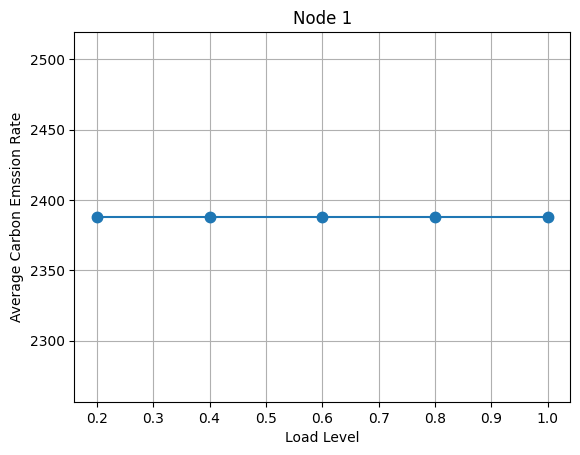

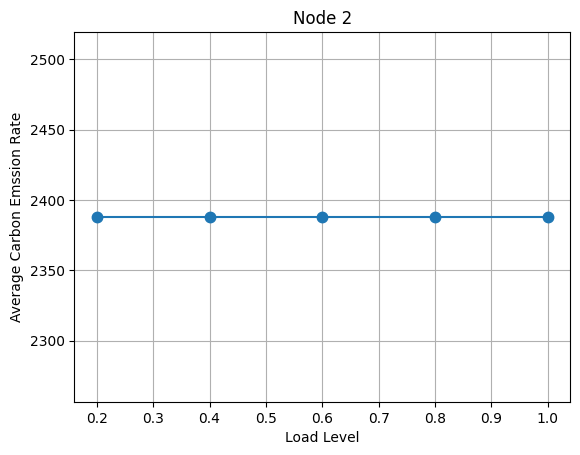

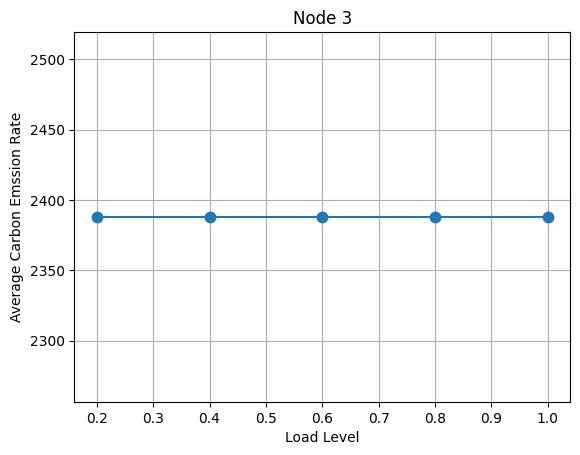

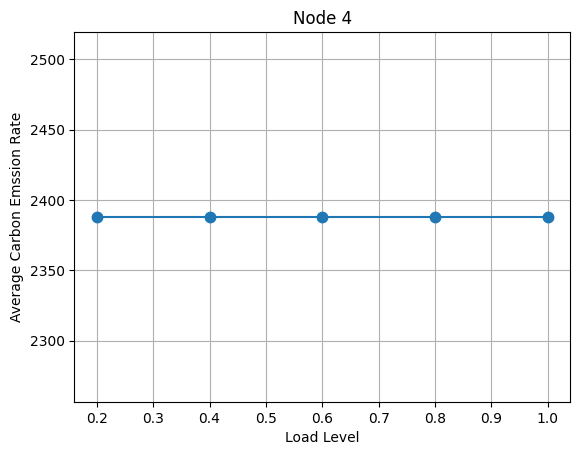

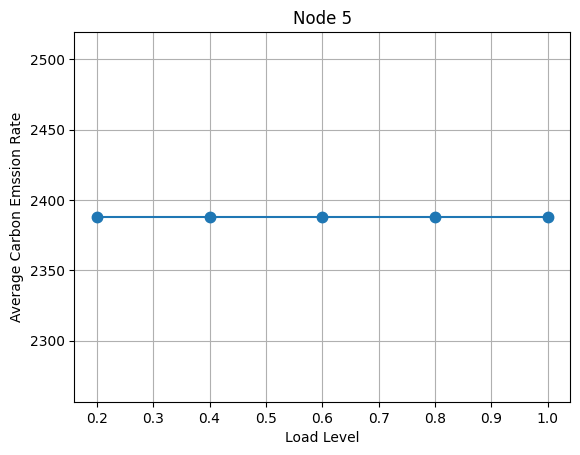

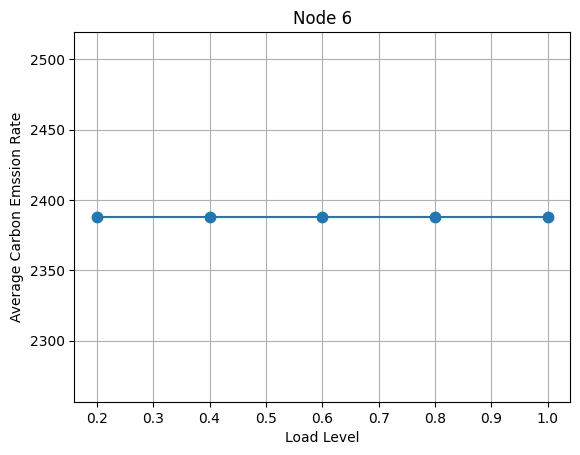

In [23]:
for n in range(num_buses):
    plt.title("Node " + str(n+1))
    plt.xlabel("Load Level")
    plt.ylabel("Average Carbon Emssion Rate")
    plt.plot([0.2,0.4,0.6,0.8,1.0], res[:, n], marker=".", markersize=15)
    plt.grid()
    plt.show()


Text(0.5, 0, 'Load Level')

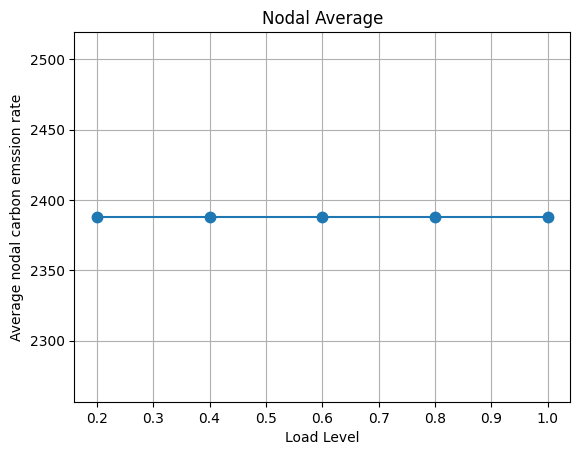

In [24]:
y = np.average(res, axis=1)
plt.title("Nodal Average")
plt.plot(percent, y, marker=".", markersize=15)
plt.grid()
plt.ylabel("Average nodal carbon emssion rate")
plt.xlabel("Load Level")